# Online Joint State and Parameter Estimation for AR SSM 
State space model
\begin{align*}
    &\mathbf{x}_t = \mathbf{A}\mathbf{x}_{t-1} + \mathbf{p}_t \quad \mathbf{p}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I}\gamma_x^{-1}) \\
    &y_t = \mathbf{c}^\text{T}\mathbf{x}_t + m_t \quad v_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

\begin{align*}
     &p(\mathbf{x}_t\,|\,\mathbf{x}_{t-1},\mathbf{a},\gamma) = \mathcal{N}\left(\mathbf{x}_t\;\middle|\; \mathbf{A}\mathbf{x}_{t-1},  \mathbf{I}\gamma_x^{-1} \right)\\
    &p(y_t\,|\,\mathbf{x}_{t}) = \mathcal{N}\left(y_t \;\middle|\;\mathbf{c}^\text{T}\mathbf{x}_t, \gamma_y^{-1} \right)
\end{align*}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\text{T} \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\text{T} 
    \\ \\
    &\mathbf{A} = 
    \begin{bmatrix}
        a_1 & a_2 & a_3 & \dots & a_p \\
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 0
    \end{bmatrix}
    =
    \begin{bmatrix}
         \mathbf{a}^\text{T} \\
         \mathbf{I}_{p-1} \quad \mathbf{0}
    \end{bmatrix}
    \\ \\
    &\mathbf{I} = \mathbf{I}_p = 
    \begin{bmatrix}
        1 & 0 & 0 & \dots & 0 \\ 
        0 & 1 & 0 & \dots & 0 \\   
        \vdots & \vdots & \vdots & \ddots & \vdots \\
        0 & 0 & 0 & \dots & 1
    \end{bmatrix} \\
\end{align*}

┌ Info: Recompiling stale cache file /Users/albertpod/.julia/compiled/v1.1/Images/H8Vxc.ji for Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1184
┌ Info: Precompiling QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1186


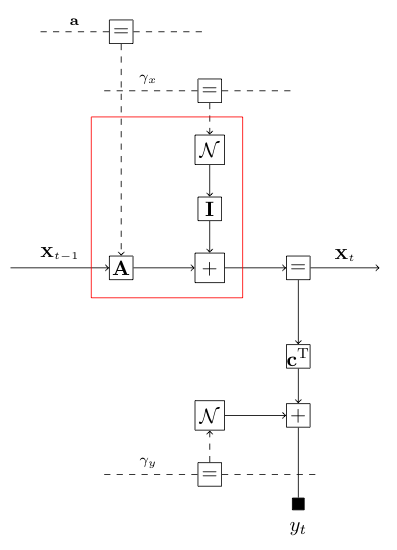

In [1]:
using Images
img = load("../ffgs/HAR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$ and states $\mathbf{x}_n$, while setting noises' precisions $\gamma_x=1$, $\gamma_y=\frac{1}{2}$.

In [19]:
using ProgressMeter
using Revise
using ForneyLab
include( "../AR-node/autoregression.jl")
include("../AR-node/rules_prototypes.jl")
include("../AR-node/vmp_rules.jl")
# helpers for evaluation of the model
include("../helpers/functions.jl")
# module to generate data for AR
include("../data/ARdata.jl")
import Main.ARdata: use_data, generate_data, generate_sin
import LinearAlgebra.I, LinearAlgebra.Symmetric
import ForneyLab: unsafeCov, unsafeMean, unsafePrecision

In [20]:
ARorder = 2 # order of AR model
diagAR(dim) = Matrix{Float64}(I, dim, dim)
x = []
# AR data
a_w = 1.0; b_w = 1.0
pn_var = a_w/b_w # process noise variance
coefs, x = generate_data(1000, ARorder, 1, noise_variance=pn_var)
#x = use_data("../data/temperature.csv", ARorder)
#coefs, x = generate_sin(1000, tiny)
mn_var = 2.0 # measurement noise variance
# Observations
y = [xi[1] + sqrt(mn_var)*randn() for xi in x[ARorder:end]]

999-element Array{Float64,1}:
 -1.1415553980063442 
  1.8555117216697772 
 -1.7418888040216816 
  1.9512197104467213 
 -4.414979394129141  
  6.219214881278515  
 -4.768983429384126  
  2.21956108315341   
  0.6228311212996223 
 -4.8925200904057355 
  2.651766937401646  
 -1.564698069212094  
  1.229077222687593  
  ⋮                  
 -4.0197885274648915 
  0.34225265551702566
  1.1651025934838186 
 -4.3181189517324485 
  4.381949746637411  
 -3.9654601858064513 
  1.9119002000518366 
 -0.4801622747022352 
 -3.0285542449661733 
  1.6772061930145206 
 -1.8326412354003248 
  3.7075729527743464 

In [21]:
# Building the model
g = FactorGraph()

# declare priors as random variables
@RV m_x_t_prev
@RV w_x_t_prev
@RV m_a_t
@RV w_a_t
@RV m_y_t

@RV a ~ GaussianMeanPrecision(m_a_t, w_a_t)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV w ~ Gamma(a_w, b_w)
@RV x_t = AR(a, x_t_prev, w)
c = zeros(ARorder); c[1] = 1.0
@RV y_t ~ GaussianMeanPrecision(m_y_t, mn_var^-1)
DotProduct(y_t, c, x_t)

# Placeholders for prior
placeholder(m_x_t_prev, :m_x_t_prev, dims=(ARorder,))
placeholder(w_x_t_prev, :w_x_t_prev, dims=(ARorder, ARorder))
placeholder(m_a_t, :m_a_t, dims=(ARorder,))
placeholder(w_a_t, :w_a_t, dims=(ARorder, ARorder))

# Placeholder for data
placeholder(m_y_t, :m_y_t)

ForneyLab.draw(g)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 9376474908568676494 -->
 
 9376474908568676494 
 
 placeholder_m_x_t_prev 
 
<!-- 7716754211604296870 -->
 
 7716754211604296870 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 9376474908568676494--7716754211604296870 -->
 
 9376474908568676494--7716754211604296870 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 18093432801630399158 -->
 
 18093432801630399158 
 
 placeholder_m_y_t 
 
<!-- 2884837948816307468 -->
 
 2884837948816307468 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 18093432801630399158--2884837948816307468 -->
 
 18093432801630399158--2884837948816307468 
 
 m_y_t 
 2 m 
 1 out 
 
<!-- 9349057001320689420 -->
 
 9349057001320689420 
 
 Autoregression 
 autoregression_1 
 
<!-- 13339444582422834385 -->
 
 13339444582422834385 
 
 Gam 
 gamma_1 
 
<!-- 9349057001320689420--13339444582422834385 -->
 
 9349057001320689420--13339444582422834385 
 
 w 
 1 out 
 4 W 
 
<!-- 9349057001320689420--7716754211604296870 -->
 
 9349057001320689420--7716754211604296870 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 16505583404530406536 -->
 
 16505583404530406536 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 9349057001320689420--16505583404530406536 -->
 
 9349057001320689420--16505583404530406536 
 
 a 
 1 out 
 3 a 
 
<!-- 13088373056250869107 -->
 
 13088373056250869107 
 
 placeholder_m_a_t 
 
<!-- 13088373056250869107--16505583404530406536 -->
 
 13088373056250869107--16505583404530406536 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 6289013904517183401 -->
 
 6289013904517183401 
 
 clamp_3 
 
<!-- 9966930120705122520 -->
 
 9966930120705122520 
 
 clamp_2 
 
<!-- 13339444582422834385--9966930120705122520 -->
 
 13339444582422834385--9966930120705122520 
 
 clamp_2 
 1 out 
 3 b 
 
<!-- 17526475677930810350 -->
 
 17526475677930810350 
 
 clamp_1 
 
<!-- 13339444582422834385--17526475677930810350 -->
 
 13339444582422834385--17526475677930810350 
 
 clamp_1 
 1 out 
 2 a 
 
<!-- 2884837948816307468--6289013904517183401 -->
 
 2884837948816307468--6289013904517183401 
 
 clamp_3 
 1 out 
 3 w 
 
<!-- 1741682090784067684 -->
 
 1741682090784067684 
 
 dot 
 dotproduct_1 
 
<!-- 1741682090784067684--9349057001320689420 -->
 
 1741682090784067684--9349057001320689420 
 
 x_t 
 1 out 
 3 in2 
 
<!-- 1741682090784067684--2884837948816307468 -->
 
 1741682090784067684--2884837948816307468 
 
 y_t 
 1 out 
 1 out 
 
<!-- 4806021377213462476 -->
 
 4806021377213462476 
 
 clamp_4 
 
<!-- 1741682090784067684--4806021377213462476 -->
 
 1741682090784067684--4806021377213462476 
 
 clamp_4 
 1 out 
 2 in1 
 
<!-- 8707323856854265998 -->
 
 8707323856854265998 
 
 placeholder_w_a_t 
 
<!-- 8707323856854265998--16505583404530406536 -->
 
 8707323856854265998--16505583404530406536 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 781889633931570525 -->
 
 781889633931570525 
 
 placeholder_w_x_t_prev 
 
<!-- 781889633931570525--7716754211604296870 -->
 
 781889633931570525--7716754211604296870 
 
 w_x_t_prev 
 3 w 
 1 out

In [22]:
# Specify recognition factorization
q = RecognitionFactorization(a, x_t, ids=[:A :X_t])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)

# Load algorithms
eval(Meta.parse(algo))

stepX_t! (generic function with 3 methods)

In [23]:
# Define values for prior statistics
m_a_0 = zeros(ARorder)
w_a_0 = diagAR(ARorder)
m_x_prev_0 = zeros(ARorder)
w_x_prev_0 = 0.1*diagAR(ARorder)

# Storage
m_x_prev = Vector{Vector{Float64}}(undef, length(y))
w_x_prev = Vector{Array{Float64, 2}}(undef, length(y))
m_a = Vector{Vector{Float64}}(undef, length(y))
w_a = Vector{Array{Float64, 2}}(undef, length(y))

# Inits
m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
m_a_t_min = m_a_0
w_a_t_min = w_a_0;

In [24]:
marginals = Dict()
# VMP iterations
n_its = 10

# Storage for estimations
means = []
precisions = []
real = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs = []
p = Progress(length(y), 1, "Observed ")
for t in 1:length(y)
    update!(p, t)
    marginals[:a] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_a_t_min, w=w_a_t_min)
    marginals[:x_t_prev] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w, b=b_w)
    global m_x_t_prev_min, w_x_t_prev_min, m_a_t_min, w_a_t_min

    for i = 1:n_its
        data = Dict(:m_y_t => y[t],
                    :m_a_t => m_a_t_min,
                    :w_a_t => w_a_t_min,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min)
        
        stepX_t!(data, marginals)
        stepA!(data, marginals)
        m_a[t] = unsafeMean(marginals[:a])
        w_a[t] = unsafePrecision(marginals[:a])
        m_x_prev[t] = unsafeMean(marginals[:x_t])
        w_x_prev[t] = unsafePrecision(marginals[:x_t])
        m_a_t_min = m_a[t]
        w_a_t_min = w_a[t]
        m_x_t_prev_min = m_x_prev[t]
        w_x_t_prev_min = w_x_prev[t]
    end
    push!(means, m_x_prev[t][1])
    push!(precisions, w_x_prev[t][1])
    push!(WMSEs, wmse(real[1:t], means, 1 ./ precisions))
end

Observed 100%|██████████████████████████████████████████| Time: 0:00:02


In [25]:
from = 1
estimated = [x[1] for x in m_x_prev[from:end]]
real = [x[1] for x in x[ARorder:end]]
noise = [y[1] for y in y[from:end]]

println("Δ(estimated, real)=", mse(estimated, real))
println("Δ(estimated, noise)=", mse(estimated, noise))
println("Δ(noise, actual)=", mse(noise, real))

Δ(estimated, real)=2.8054178319302507
Δ(estimated, noise)=3.3918827612462183
Δ(noise, actual)=1.9727978073303487


In [26]:
println("Inferred ", mean(marginals[:a]))
println("Real ", coefs)

Inferred [-0.669085, 0.02405]
Real [-1.54246, -0.770829]


In [27]:
using Plots

scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(estimated)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(noise) - .1, maximum(noise) + .1);
    scatter!(collect(i:i+toshow), noise[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), [estimated[i:i+toshow], estimated[i:i+toshow]], fillrange=[estimated[i:i+toshow] -
          scale .* sqrt.(v_x[i:i+toshow]), estimated[i:i+toshow] + scale .* sqrt.(v_x[i:i+toshow])],
          linestyle=:dash, linewidth = 2,
          color=:black,
          fillalpha = 0.2,
          fillcolor = :black,
          label="inferred")
    
    plot!(collect(i:i+toshow), real[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpleCThD", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000980.png", "000981.png", "000982.png", "000983.png", "000984.png", "000985.png", "000986.png", "000987.png", "000988.png", "000989.png"])

In [28]:
gif(anim, "../gifs/KMPstate.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/gylTh/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/KMPstate.gif")

In [14]:
# Plotting MSE
anim = @animate for i in 1:length(WMSEs)
    s = plot()
    ylims!(minimum(WMSEs) - 1, maximum(WMSEs) + 1)
    xlims!(1, length(WMSEs))
    plot!(collect(1:i), WMSEs[1:i], xlabel="observation", ylabel="WMSE", label="")
end;

In [15]:
gif(anim, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Desktop/VMP-AR/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/QYETN/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Desktop/VMP-AR/gifs/MSE_evo_state.gif")

# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = 1.0$ and $\gamma_y = \frac{1}{2}$

In [29]:
rwg = FactorGraph()

# declare priors as random variables
@RV m_x_t_min
@RV w_x_t_min
@RV x_t_min ~ GaussianMeanPrecision(m_x_t_min, w_x_t_min)

@RV n_t ~ GaussianMeanPrecision(0.0, 1.0)
@RV x_t = x_t_min + n_t
@RV m_t ~ GaussianMeanPrecision(0.0, mn_var^-1)
@RV y_t = x_t + m_t

# Placeholders for prior
placeholder(m_x_t_min, :m_x_t_min)
placeholder(w_x_t_min, :w_x_t_min)

# Placeholder for data
placeholder(y_t, :y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 6039790780037669388 -->
 
 6039790780037669388 
 
 clamp_2 
 
<!-- 3541789262088902582 -->
 
 3541789262088902582 
 
 placeholder_m_x_t_min 
 
<!-- 12704230717460131895 -->
 
 12704230717460131895 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 3541789262088902582--12704230717460131895 -->
 
 3541789262088902582--12704230717460131895 
 
 m_x_t_min 
 2 m 
 1 out 
 
<!-- 11861752302617248496 -->
 
 11861752302617248496 
 
 + 
 addition_1 
 
<!-- 2574253698174565158 -->
 
 2574253698174565158 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 11861752302617248496--2574253698174565158 -->
 
 11861752302617248496--2574253698174565158 
 
 n_t 
 1 out 
 3 in2 
 
<!-- 11861752302617248496--12704230717460131895 -->
 
 11861752302617248496--12704230717460131895 
 
 x_t_min 
 1 out 
 2 in1 
 
<!-- 2574253698174565158--6039790780037669388 -->
 
 2574253698174565158--6039790780037669388 
 
 clamp_2 
 1 out 
 3 w 
 
<!-- 3575125391660713727 -->
 
 3575125391660713727 
 
 clamp_1 
 
<!-- 2574253698174565158--3575125391660713727 -->
 
 2574253698174565158--3575125391660713727 
 
 clamp_1 
 1 out 
 2 m 
 
<!-- 4879862602676564076 -->
 
 4879862602676564076 
 
 + 
 addition_2 
 
<!-- 4879862602676564076--11861752302617248496 -->
 
 4879862602676564076--11861752302617248496 
 
 x_t 
 1 out 
 2 in1 
 
<!-- 11336796205178618660 -->
 
 11336796205178618660 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 4879862602676564076--11336796205178618660 -->
 
 4879862602676564076--11336796205178618660 
 
 m_t 
 1 out 
 3 in2 
 
<!-- 1001712425576515553 -->
 
 1001712425576515553 
 
 placeholder_y_t 
 
<!-- 1001712425576515553--4879862602676564076 -->
 
 1001712425576515553--4879862602676564076 
 
 y_t 
 1 out 
 1 out 
 
<!-- 9431881644762310582 -->
 
 9431881644762310582 
 
 placeholder_w_x_t_min 
 
<!-- 9431881644762310582--12704230717460131895 -->
 
 9431881644762310582--12704230717460131895 
 
 w_x_t_min 
 3 w 
 1 out 
 
<!-- 6505950583342485178 -->
 
 6505950583342485178 
 
 clamp_4 
 
<!-- 2348736821610691399 -->
 
 2348736821610691399 
 
 clamp_3 
 
<!-- 11336796205178618660--6505950583342485178 -->
 
 11336796205178618660--6505950583342485178 
 
 clamp_4 
 1 out 
 3 w 
 
<!-- 11336796205178618660--2348736821610691399 -->
 
 11336796205178618660--2348736821610691399 
 
 clamp_3 
 1 out 
 2 m

In [30]:
algo = sumProductAlgorithm(x_t)
eval(Meta.parse(algo))

# Define values for prior statistics
m_x_0 = 0.0
w_x_0 = 0.01

n_samples = length(y)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_min = m_x_0
w_x_t_min = w_x_0

# Storage for estimations
means_rw = []
precisions_rw = []
real_rw = [x[1] for x in x[ARorder:end]]
# Storage for MSE of test set
WMSEs_rw = []

for t = 1:n_samples
    # Prepare data and prior statistics
    data = Dict(:y_t        => y[t],
                :m_x_t_min => m_x_t_min,
                :w_x_t_min => w_x_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_x_t_min = mean(marginals[:x_t])
    w_x_t_min = var(marginals[:x_t])^-1
    
    # Store to buffer 
    m_x[t] = m_x_t_min
    w_x[t] = w_x_t_min
    push!(means_rw, m_x_t_min)
    push!(precisions_rw, w_x_t_min)
    push!(WMSEs_rw, wmse(real[1:t], means_rw, 1 ./ precisions_rw))
end

# Comparison
To assess the performance of our model, we use the following metric:
$$\sum_{i=1}^Te^{i-T}\frac{(m_{x_{k}}-x_{k})^2}{{v_{x_{k}}}}$$
where
$m_{x_{k}}$ - estimated mean of the hidden state,
$v_{x_{k}}$ - estimated variance of the hidden state,
$T$ - number of available observations

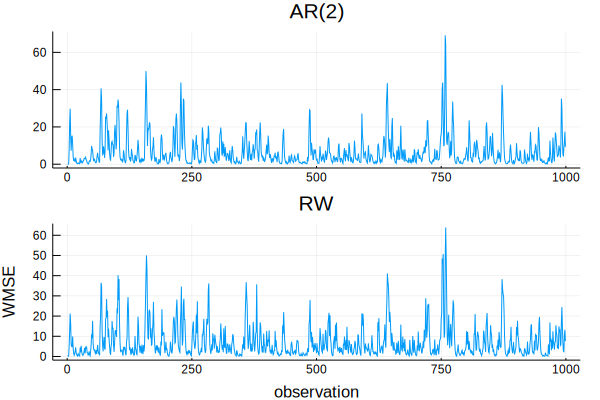

In [31]:
# Plotting
using Plots
pAR = plot(WMSEs, title="AR($ARorder)", label="")
pRW = plot(WMSEs_rw, xlabel="observation", ylabel="WMSE", title="RW", label="")
plot(pAR, pRW, layout=(2,1))

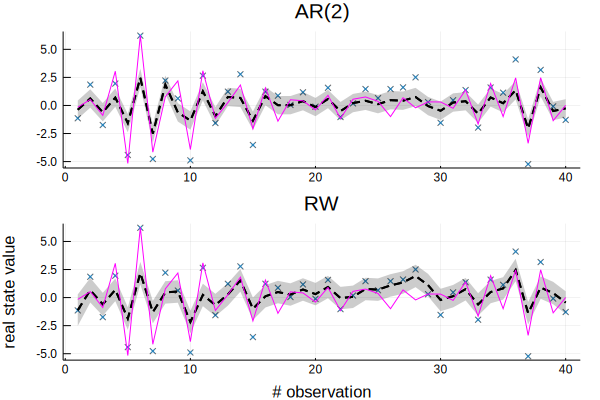

In [32]:
from = 1
upto = 40 # limit for building a graph 
scale = 1.0 # scale for the variance
v_x = [v_x[1]^-1 for v_x in w_x[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_x[from:upto], m_x[from:upto]], fillrange=[m_x[from:upto] -
      scale .* sqrt.(v_x[from:upto]), m_x[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="# observation", ylabel="real state value", title="RW")


v_x = [v_x[1]^-1 for v_x in w_x_prev[1:end]] # variances of estimated state
scatter(noise[from:upto], label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([estimated[from:upto], estimated[from:upto]], fillrange=[estimated[from:upto] -
      scale .* sqrt.(v_x[from:upto]), estimated[from:upto] +
      scale .* sqrt.(v_x[from:upto])],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(real[from:upto], color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, layout=(2,1), legend=false)

In [33]:
sum(WMSEs)

6645.064417725522

In [34]:
sum(WMSEs_rw)

7290.522879543146